# Movie Net Profit Exploration

#### Jason Buckley and Bobby Davis
#### 8 May 2020


In [ ]:
# importing libraries, and plot context 
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer

sns.set()
rcParams['figure.figsize'] = 8,6
sns.set_context('talk') 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Introduction

Here we will be attempting to predict the net profit a movie might generate. We will also be determining what factors play a significant role in how well a movie does.

The dataset we will be working with comes from kaggle. The actual data was gathered from "The Movie Database", more commonly referred to as TMDb. Since the data comes from TMDb, the information was inputted by users of the site. The dataset is comprised of thousands of movies and basic information for each movie such as genre, budget, and revenue to name a few. 

The dataset we used can be found here: https://www.kaggle.com/tmdb/tmdb-movie-metadata/data

Dataset Last updated: April 28, 2020

## Initial Exploration

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/movie_data/tmdb_5000_movies.csv')

To get a general idea of the data we will be working with we should look at the names of columns, types of each column, and the number of rows.

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


We can get a good, initial visualization of our numerical data and any correlations that might exist by using sns.pairplot() provided to us by seaborn.

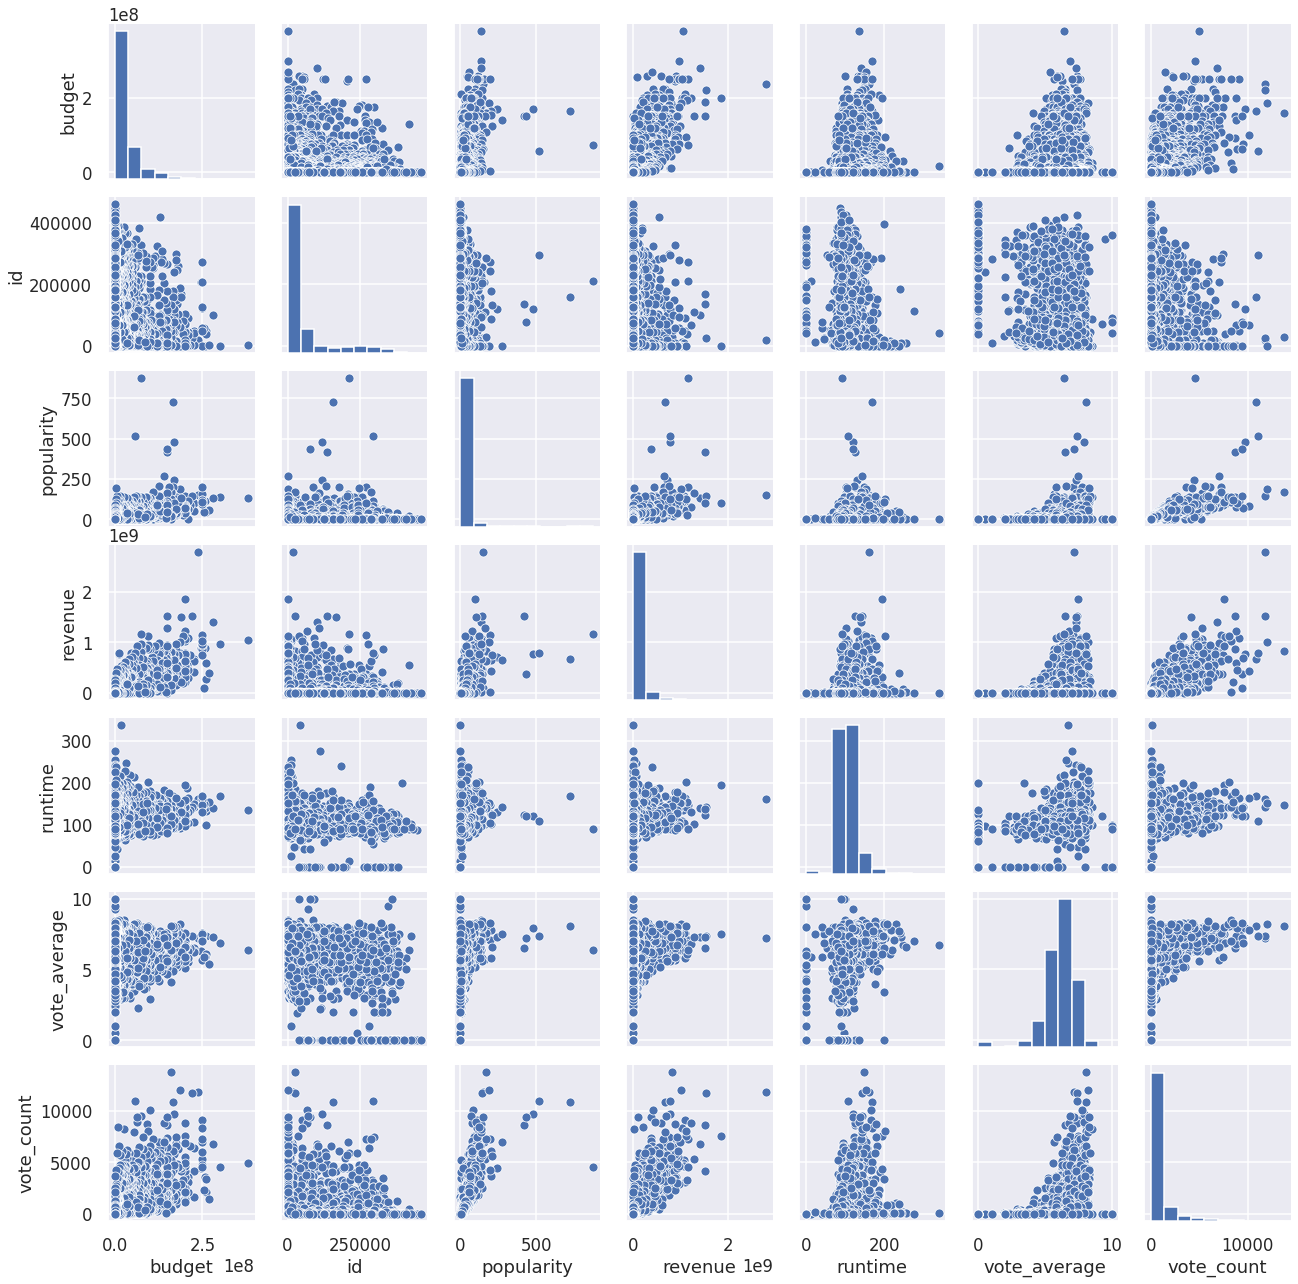

In [ ]:
sns.pairplot(df);

If you look at budget vs popularity it doesn't look like movies with bigger budgets are guaranteed to make more money. It also looks like movies that are either too short or too long do not seem to be as popular. Movies around the same runtime as the most popular movies also seem to bring in the most revenue.

## Data cleaning


TOTAL NA VALUES IN DF:
0.041026441807203835

FRACTION OF NA VALUES FOR EACH COLUMN:
homepage                0.643556
tagline                 0.175724
overview                0.000625
runtime                 0.000416
release_date            0.000208
vote_count              0.000000
genres                  0.000000
id                      0.000000
keywords                0.000000
original_language       0.000000
original_title          0.000000
production_companies    0.000000
popularity              0.000000
vote_average            0.000000
production_countries    0.000000
revenue                 0.000000
spoken_languages        0.000000
status                  0.000000
title                   0.000000
budget                  0.000000
dtype: float64

COLUMNS WITH MORE THEN 50% NA VALUES
Index(['homepage'], dtype='object')

Columns with more than 0% NA values


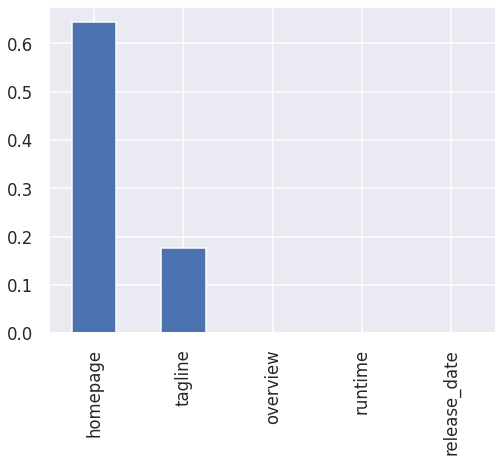

In [ ]:
print("\nTOTAL NA VALUES IN DF:")
total_NA = df.isna().mean().mean()
print(str(total_NA) + "\n")

print("FRACTION OF NA VALUES FOR EACH COLUMN:")
frac_NA = df.isna().mean().sort_values(ascending=False)
print(str(frac_NA) + "\n")

print("COLUMNS WITH MORE THEN 50% NA VALUES")
print(frac_NA[frac_NA > .50].index.sort_values())

# plot columns bigger then 0% NA values
print("\nColumns with more than 0% NA values")
frac_NA[frac_NA > 0].plot.bar()

As we can see, the homepage column has quite a few NA values and the other values are not particularly useful to us as either. For these reasons we will definitely drop this column.

NA values may not be the only bad values in our dataset. Below is a list of columns that contain zeros. The total amount of zeros in each column is shown as well.

In [ ]:
for col in df:
  if (df[col] == 0).sum() > 0:
    print(col + ": " + str((df[col] == 0).sum()))

budget: 1037
popularity: 1
revenue: 1427
runtime: 35
vote_average: 63
vote_count: 62


We decided to only consider the zeros in the revenue column as bad data since the meaning of the zero is too ambiguous and the total amount of rows containing zeros is very high. Does this mean that the movie made no money or does it mean the amount of revenue is unknown? There is no way for us to really tell and it seems highly unlikely that a movie made absolutely no revenue at all. 

Even though budget also has a high count of zeros, it is not uncommon for short films to be made with no budget. For this reasoning we left the budget column alone.

In [ ]:
#Drop all rows with a value of 0 in the revenue column
print("Before removing zeros:" + str(df.shape))
df = df[(df['revenue'] != 0)]
print("After removing zeros" + str(df.shape))

Before removing zeros:(4803, 20)
After removing zeros(3376, 20)


In the graph below we can see that the status column consists of a single value and is therefore unusable.

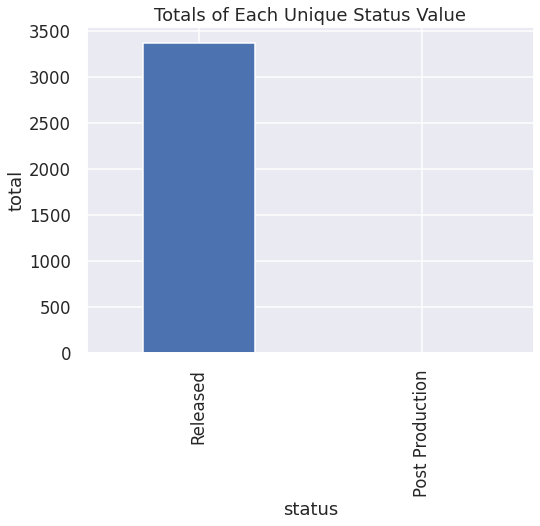

In [ ]:
temp2 = df["status"].value_counts().sort_values(ascending=False)
ax2 = temp2.plot.bar()
ax2.set_title('Totals of Each Unique Status Value')
ax2.set_ylabel('total')
ax2.set_xlabel('status');

We also found it appropriate to remove tagline, id and overview from our dataset. Tagline contained short slogans to promote each movie. Id just had unique numbers to identify each movie. Overview had lengthy text describing the plot of each movie. None of these columns would be much use to us, so we dropped them all as well.

In [ ]:
#drop useless columns
df = df.drop(['homepage', 'id', 'status', 'tagline', 'overview', 'keywords','original_title','title','release_date'], axis=1);

As well, we will add a new column called 'net profit' to the database by subtracting budget from revenue.  

In [ ]:
df['net_profit'] = df['revenue'] - df['budget']

At first glance the columns such as genres, and spoken languages look unuseable for determing a movies net profit; however, if we convert the data into aggregate values we can use them in a regression model. By converting the below values into counts rather than lists we obtain more meaning full data to assess a movie's net profit. 

In [ ]:
# currently every value is stored in a list of json objects so we can separate them by a '},'
df['genres'] = df['genres'].apply(lambda x: len(x.split('},')))
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: len(x.split('},')))
df['production_countries'] = df['production_countries'].apply(lambda x : len(x.split('},')))
df['production_companies'] = df['production_companies'].apply(lambda x : len(x.split('},')))

The original_language column has a large variety of values, but most of them are English. To make this column more useable will convert them to numerical values. We will use 1 to represent "english" and 0 to represent "not english". We will also rename the column to avoid confusion.

In [ ]:
df['original_language'] = pd.Series(np.where(df.original_language.values == 'en', 1, 0), df.index)

In [ ]:
df = df.rename(columns={'original_language':'english_or_not'})
df['english_or_not'].value_counts()

1    3233
0     143
Name: english_or_not, dtype: int64

## Data exploration and visualization

### Is it common for movies to make a net profit over 100 million dollars?

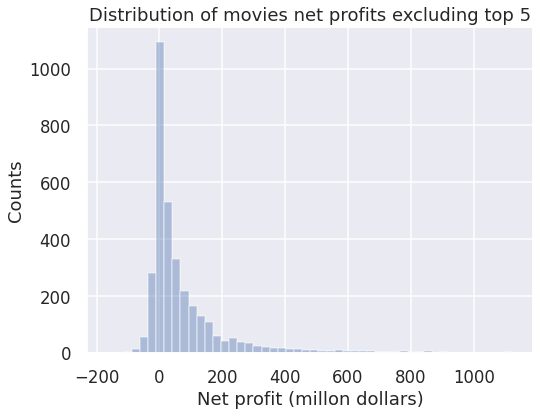

In [ ]:
sns.distplot(df.net_profit[(df.net_profit < df.net_profit.nlargest(5).min())]/1000000,kde=False)
plt.xlabel("Net profit (millon dollars)")
plt.ylabel("Counts")
plt.title("Distribution of movies net profits excluding top 5");

It does not appear that many movies make a net profit over 100 million dollars.  According to the histogram of the distribution it appears that the majority of movies make far under 100 million dollars. This is indicated by the peak being around 0 to 20 million dollars, and the peak containing roughly a third of the data.  However, that does not necessarily mean a movies is not profitable.  To get a better look at whether a movies is profitable lets look at the ratio of revenue to budget spent on the movie.

Below is a plot of the distribution of profit to budget spent excluding values that were 1.5 times outside the interquartile range of the data.


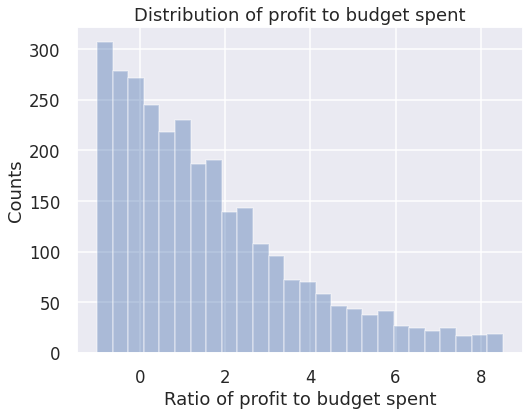

1st quartile: 0.022
Median: 1.300
3rd quartile: 3.421


In [ ]:
a = df.net_profit / df.budget
a = a[a != np.inf]
first, median, third =  a.quantile([0.25,0.5,0.75]).values
iqr = third - first
sns.distplot(a[((a < (third + iqr*1.5)) & (a > (first - iqr*1.5)))], kde=False)
plt.title("Distribution of profit to budget spent")
plt.xlabel("Ratio of profit to budget spent")
plt.ylabel("Counts")
plt.show();

print("1st quartile: %.3f" % first)
print("Median: %.3f" % median)
print("3rd quartile: %.3f" % third)

This plot, and the median of the data on profit to budget spent shows us that it is common for a movie to generate 1.3 times, or less than what was spent on the budget.  As well, the amount of movies appear to exponentially decay as the ratio of profit to budget spent increases indicating that it is rather rare for a movie to make more than 3.5 times the budget spent.  

### Does the amount of votes impact a movie's popularity?

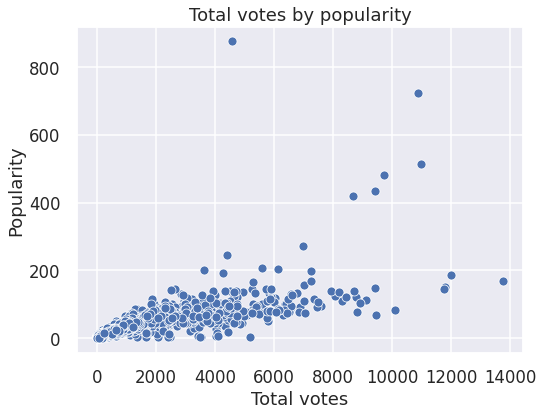

In [ ]:
sns.scatterplot(df.vote_count, df.popularity)
plt.xlabel("Total votes")
plt.ylabel("Popularity")
plt.title("Total votes by popularity");

It appears that the amount of votes a movie gets has a slight impact on its popularity.  The general trend of the data above shows a positive association between total votes, and popularity.  However, it looks like most of the data is clustered between 0-4000 votes so perhaps our analysis is being skewed by a small portion of the data.  

Lets take look at Total votes by popularity for movies that have less than 4000 votes.

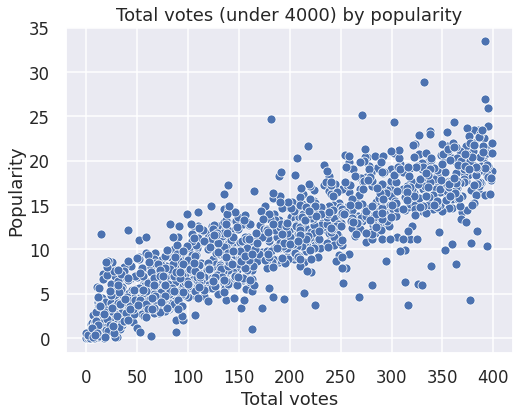

In [ ]:
sns.scatterplot(df.vote_count[df.vote_count < 400], df.popularity)
plt.xlabel("Total votes")
plt.ylabel("Popularity")
plt.title("Total votes (under 4000) by popularity");

This graph shows that are analysis was being skewed by a small portion of the data.  It shows that there is a more definitive positive association between the total votes, and popularity.  

### Are some features highly correlated with others?


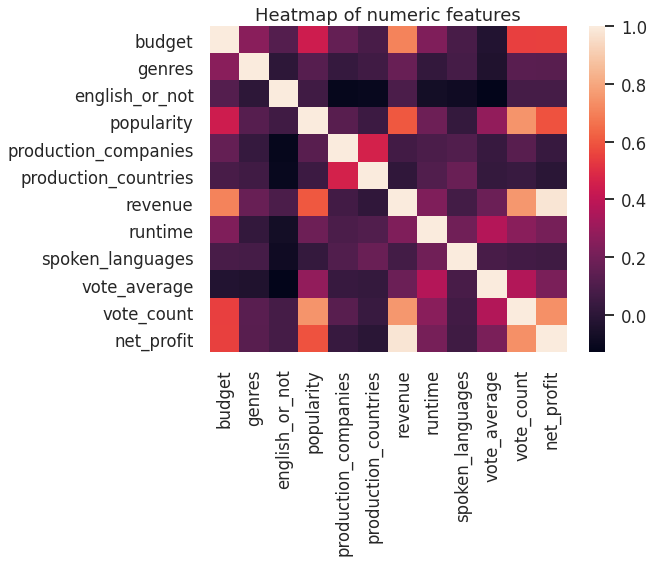

In [ ]:
sns.heatmap(df.corr())
plt.title("Heatmap of numeric features");

Similar to the last plot, the heatmap shows us that popularity and vote counts are highly correlated.  As well, the heatmap suggests that vote count has a high correlation with net profit and revenue.  It also shows that there are moderate correlations between net profit and popularity, and net profit and budget.  So it appears that some features are highly, or moderately correlated, but majority remain very lowly correlated to each other.  

## Machine learning

Since our data is mainly numerical and we are only interested in predicting net profit, we will be utilizing regression. In order for regression to function properly we will need to replace any categorical data with numerical variables. To do this we will use the get_dummies() function provided to us by pandas.

In [ ]:
df2 = pd.get_dummies(df, drop_first = True)

In [ ]:
# forward selection for regression models
def forward_selection(X_train, y_train, max_features, classifier):
    remaining = list(range(X_train.shape[1]))
    selected = []
    # limiting max features to 6 by default to prevent overfitting
    n = max_features if max_features != None else 6
    
    while(len(selected) < n):
        # find the single features that works best together
        # with the previously selected features
        rmse_min = 1e12
        i_min = remaining[0]
        
        for i in remaining:
            X_i = X_train[:,selected+[i]] 
            scores = -cross_val_score(classifier, X_i, y_train, scoring='neg_mean_squared_error',cv=5)
            
            rmse = np.sqrt(scores.mean())
            
            # looking for the next feature that minimizes rmse
            rmse_min = min(rmse_min,rmse)
            i_min = i_min if rmse != rmse_min else i
        
        remaining.remove(i_min)
        selected.append(i_min)
    
    return selected

In [ ]:
def plot_actual_predicted(actual, predicted, title):
    minA = np.amin(actual)
    minP = np.amin(predicted)
    maxA = np.amax(actual)
    maxP = np.amax(predicted)
    
    sns.scatterplot(x=actual, y=predicted, data=df)
    plt.plot([minA, maxP], [minA, maxP], color = 'black', linestyle='dashed')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)

# Linear Regression

For our first model we will use linear regression with as many features as possible as a starting basis. Since our goal is to predict net profit, we will be excluding revenue from our list of predictors as it would not make much sense for us to already know how much money a movie made. 

**Model 1: Linear Regression without Polynomial Features and Forward Selection**

In [ ]:
columns = df2.columns[(df2.columns != 'net_profit') & (df2.columns != 'revenue')]

X = df2.loc[:, (df2.columns != 'net_profit') & (df2.columns != 'revenue')] #predictors
y = df2['net_profit'].values #target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=387)
reg1 = LinearRegression()
reg1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

To get an idea of how well our first model did, let's plot the predicted net profit against the actual net profit for the test data. We will also print out the RMSE and R^2 values for later comparisons.

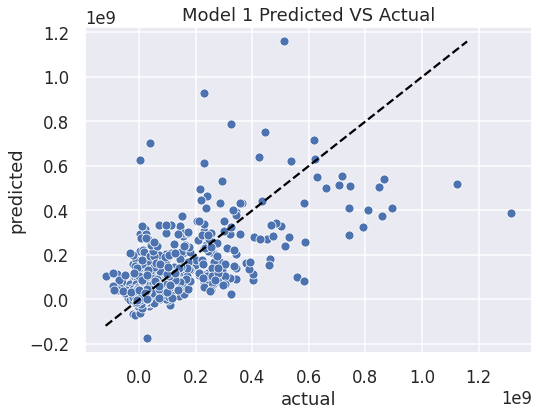

In [ ]:
plot_actual_predicted(y_test, reg1.predict(X_test), 'Model 1 Predicted VS Actual')

In [ ]:
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, reg1.predict(X_test)))))
print('r-squared: {:.4f}'.format(reg1.score(X_train, y_train)))

RMSE: 107664339.03
r-squared: 0.6349


Looking at the actual vs predicted graph, it is clear that our model is not doing so well. Majority of the points are pretty far off from the line. Since we used as many features as possible, there is a high possiblity that overfitting may have occured. We can check for overfitting by graphing the learning curve.

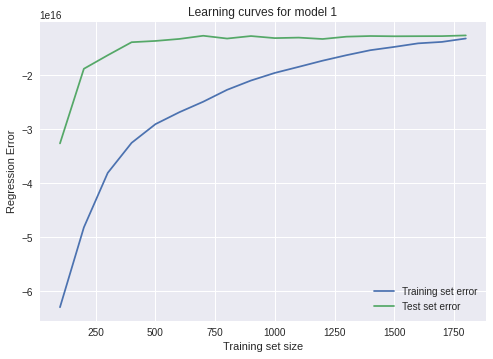

In [ ]:
train_sizes = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800]
train_sizes, train_scores, validation_scores = learning_curve(reg1, X, y, train_sizes = train_sizes, cv=5, scoring='neg_mean_squared_error')

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores.mean(axis=1), label = 'Training set error')
plt.plot(train_sizes, validation_scores.mean(axis=1), label = 'Test set error')
plt.ylabel('Regression Error')
plt.xlabel('Training set size')
plt.title('Learning curves for model 1')
plt.legend();

Above we can see that there is a moderately big gap between both lines that quickly closes as the training size increases. This is a sign that our model is exhibiting high bias.

**Model 2: Linear Regression with Polynomial Features and Forward Selection**

For our second model we are going to try to find more, and better features through making polynomial features based on the original ones.  We will limit the degree of the polynomial to two.

In [ ]:
pf = PolynomialFeatures(2)
pf.fit_transform(X)
X_poly = pf.transform(X)
feature_names = pf.get_feature_names()

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=387)

After the polynomial features have been generated, and split into separate test and training sets we will apply forward selection to find the best features.  We are going to limit the overall amount of features to 15 avoid overfitting.

Below are the polynomial features used.

In [ ]:
selected = forward_selection(X_train, y_train, 15, LinearRegression())

print("Polynomial features used: ")
for i in selected:
  a = feature_names[i].split()
  poly_feature = ""

  for k in a:
    if k == 1:
        poly_feature += str(1) + " * "
    elif (k[-2] != '^'):
        poly_feature += str(columns[int(k[1:])]) + " * "
    else:
        poly_feature += str(columns[int(k[1:-2])]) + " * "
  
  print("\t" + str(i) + ": " + str(poly_feature[:-2]))

reg2 = LinearRegression()
reg2.fit(X_train[:,selected], y_train);

Polynomial features used: 
	59: runtime * vote_count 
	20: budget * vote_count 
	23: genres * popularity 
	50: production_companies * vote_count 
	18: budget * spoken_languages 
	52: production_countries * runtime 
	44: popularity * vote_count 
	39: popularity * production_companies 
	47: production_companies * runtime 
	40: popularity * production_countries 
	26: genres * runtime 
	45: production_companies 
	63: vote_average 
	9: vote_average 
	46: production_companies * production_countries 


Next we will evaluate how well the model performed using a best fit line, rmse, and the r-squared value.

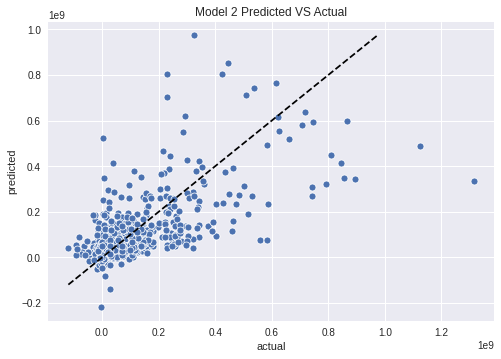

RMSE: 104494303.23
r-squared: 0.6852


In [ ]:
plot_actual_predicted(y_test, reg2.predict(X_test[:,selected]), "Model 2 Predicted VS Actual")
plt.show();

print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, reg2.predict(X_test[:,selected])))))
print('r-squared: {:.4f}'.format(reg2.score(X_train[:,selected], y_train)))

Similar to model 1 there still appears to be many points that stray quite far away from the best fit line.  However, it appears that model 2 did a slightly better job at mimimizing rmse.  As well, model 2 explains the variation in net profit slighlty better.  This is indicated by model 2 having a higher r-squared value of 0.6852 compared to 0.6349.  

To get more insight on how well model 2 performed lets take a look at the learning curve below.

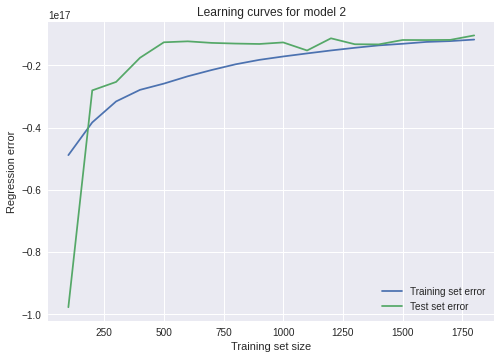

In [ ]:
train_sizes = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800]
train_sizes, train_scores, validation_scores = learning_curve(reg2, X_poly[:,selected], y, train_sizes = train_sizes, cv=5, scoring='neg_mean_squared_error')

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores.mean(axis=1), label = 'Training set error')
plt.plot(train_sizes, validation_scores.mean(axis=1), label = 'Test set error')
plt.ylabel('Regression error')
plt.xlabel('Training set size')
plt.title('Learning curves for model 2')
plt.legend()
plt.show();

Finding more, and better features through using polynomial features appears to have decreased the amount of bias in the model. However, for training sizes between 250 and 1000 it appears to have added some variance.  Although model 2 has some variance between 250 and 1000, it appears to fit the data decently for training sizes greater than 1000.

### Tree Regression

**Model 3: Tree Regression without Forward Selection and Grid Search**

Next we will test to see if tree regression performs any better. Again, we will start off by using all of the features except for revenue. 

In [ ]:
np.random.seed(387)

In [ ]:
predictors = df2.loc[:, (df2.columns != 'net_profit') & (df2.columns != 'revenue')]

X = df2.drop(labels=['net_profit','revenue'], axis=1).values #predictors
y = df['net_profit'].values #target

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=387)
# train the tree model
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train);

Did our tree model do any better than our two linear regression models? Let's find out.

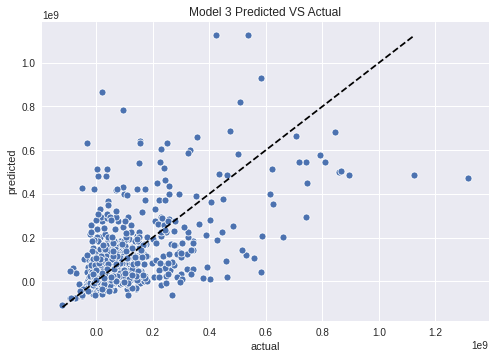

In [ ]:
plot_actual_predicted(y_test, regressor.predict(X_test), 'Model 3 Predicted VS Actual')

Unfortunatley it looks like our first tree model may have performed worse. If you look at the most dense spot near the bottom left, the points appear to be spread out a bit more when compared to both linear regression models. Let's check the RMSE value to help verify this observation.

In [ ]:
y_predict = regressor.predict(X_test)
errors = y_test - y_predict
rmse = np.sqrt((errors**2).mean())
print("RMSE: {:.2f}".format(rmse))

RMSE: 128527671.60


Our lowest RMSE was a value of 107009299.16 dollars which came from model 2. The RMSE has increased quite a bit. Out of curiosity what does the learning curve look like for this model?

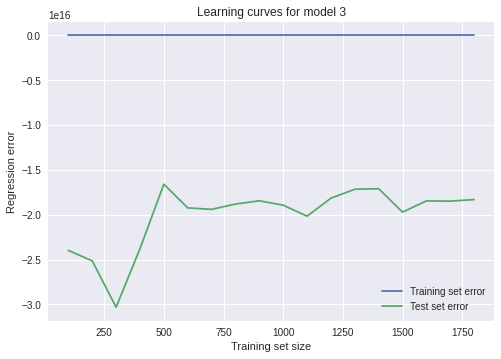

In [ ]:
train_sizes = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800]
train_sizes, train_scores, validation_scores = learning_curve(regressor, X, y, train_sizes = train_sizes, cv=5, scoring='neg_mean_squared_error')

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores.mean(axis=1), label = 'Training set error')
plt.plot(train_sizes, validation_scores.mean(axis=1), label = 'Test set error')
plt.ylabel('Regression error')
plt.xlabel('Training set size')
plt.title('Learning curves for model 3')
plt.legend();

Looking at the graph above a few key things stand out right away. First we see that the training curve starts out flat and remains flat throughout the whole graph. This indicates high bias. We also notice that there is a very huge gap between both lines. This indicates high variance. Finally we see that the test curve fluctuates quite a bit. In conclusion, model 3 performs quite poorly.

 **Model 4: Tree Regression with Forward Selection and Grid Search**

For our next tree regression model we will try to reduce bias and overfitting through using forward selection to only pick the seven best features.  

In [ ]:
np.random.seed(387)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=387)

# choosing features using forward selection
selected = forward_selection(X_train, y_train, 7, DecisionTreeRegressor())

print("Best features: ")
for i in selected:
  print("\t" + str(columns[i]))
print()

Best features: 
	budget
	english_or_not
	production_countries
	vote_count
	spoken_languages
	runtime
	popularity



As well, we will use grid search to examine which parameters work best for the tree.  We are limiting the max depth of the tree between 10-15 to prevent severe overfitting as seen in model 3.  

In [ ]:
# making a grid and selecting a scorer for grid search
scoring = make_scorer(r2_score)
grid = [{'max_depth': [i for i in range(10,15)], 'min_samples_leaf':[2,3,4,5], 'max_features': [i for i in range(2,7)]
         , 'random_state':[387]}]

# Using grid search to determine which parameters work best
reg3 = GridSearchCV(DecisionTreeRegressor(), grid, scoring=scoring, cv=5)
reg3.fit(X_train[:,selected], y_train);

print("Best values for parameters: ")
for param, value in reg3.best_params_.items():
  print("\t%s: %d" % (param, value))


Best values for parameters: 
	max_depth: 12
	max_features: 2
	min_samples_leaf: 4
	random_state: 387


Now that we have systematically found the best features, and parameters it is time to assess how well the model worked.  



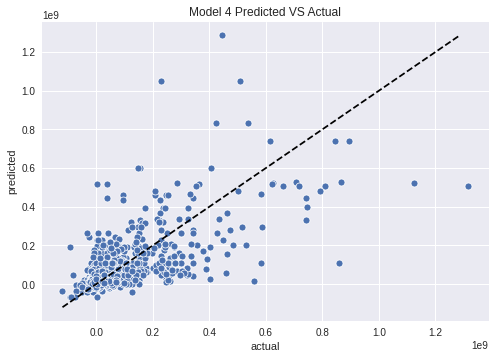

RMSE: 111216795.88
r-squared: 0.7691


In [ ]:
plot_actual_predicted(y_test, reg3.predict(X_test[:,selected]), "Model 4 Predicted VS Actual")
plt.show();

print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, reg3.predict(X_test[:,selected])))))
print('r-squared: {:.4f}'.format(reg3.score(X_train[:,selected], y_train)))

This model does a better job at minimizing rmse than model 3, 111216795.88 dollars compared to 128527671.60 dollars.  There are a large amount of points to close the best fit line; however, it appears that there are a small amount weighing down the rmse.  Although it is not able to beat model 2's rmse of 107009299.16 dollars, its r-squared value indicates it is able to explain 76.91 percent of the variation in the model.  

Below are the learning curves for model 4.

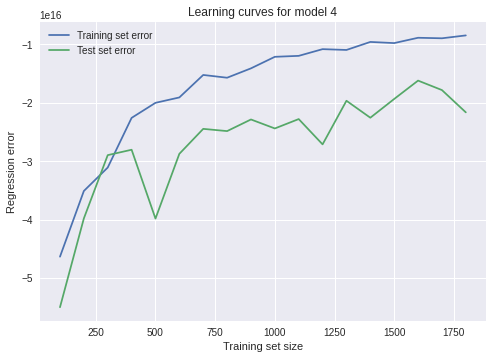

In [ ]:
train_sizes = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800]
train_sizes, train_scores, validation_scores = learning_curve(reg3.best_estimator_, X[:,selected], y, train_sizes = train_sizes, cv=5, scoring='neg_mean_squared_error')

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores.mean(axis=1), label = 'Training set error')
plt.plot(train_sizes, validation_scores.mean(axis=1), label = 'Test set error')
plt.ylabel('Regression error')
plt.xlabel('Training set size')
plt.title('Learning curves for model 4')
plt.legend();

The learning curves show that by systematically tuning the model we were able to reduce the bias in the model.  There is still some bias in the model indicated by the training curve establishing a bit quickly, and the test curve flattening some.  As well, model 4 has a slightly high variance, but drastically better than the tree regressor used in model 3.  

### KNN Regression

Finally, we will test to see how KNN regression does as compared to the last four models. Just as before our first model will use all features excluding revenue. This time we will scale our data since KNN is a distance based model and we do not want any extreme values to skew our results. We will also start by only checking the three closest neighbors and build up from there since KNN predictions are such computationally expensive operations to perform.

**Model 5: KNN Regression without Grid Search**

In [ ]:
    X = df2.loc[:, (df2.columns != 'net_profit') & (df2.columns != 'revenue')].values #predictors
    y = df['net_profit'].values #target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=387)

In [ ]:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

In [ ]:
    knn1 = KNeighborsRegressor(3)
    knn1.fit(X_train, y_train)
    predictions1 = knn1.predict(X_test)
    rmse1 = np.sqrt(((predictions1 - y_test)**2).mean())
    print('sklearn: rmse: {:.4f}'.format(rmse1))
    print('r-squared: {:.4f}'.format(knn1.score(X_train, y_train)))

sklearn: rmse: 105631283.5219
r-squared: 0.7845


So far this is the lowest rmse we have seen. Let's check the learning curve for this model.

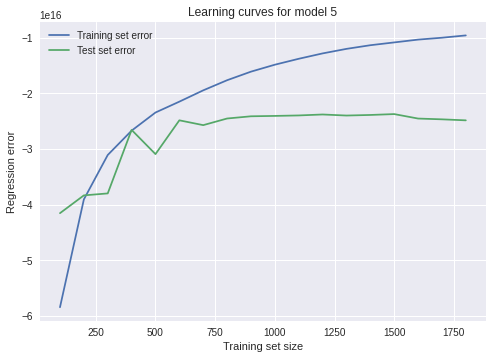

In [ ]:
train_sizes = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800]
train_sizes, train_scores, validation_scores = learning_curve(knn1, X, y, train_sizes = train_sizes, cv=5,scoring='neg_mean_squared_error')

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores.mean(axis=1), label = 'Training set error')
plt.plot(train_sizes, validation_scores.mean(axis=1), label = 'Test set error')
plt.ylabel('Regression error')
plt.xlabel('Training set size')
plt.title('Learning curves for model 5')
plt.legend();

Here we can see that as the training size increases, variance tends to increase. The test curve slightly follows the training curve from around 125 to 375 with a bit of variance.

**Model 6: KNN Regression with Forward Selection, and Grid Search**

We are going to try to decrease the amount of variance in this model through picking less features.  For model 6 we will only select 6 features using forward selection to find the best.  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=387)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

selected = forward_selection(X_train, y_train, 6, KNeighborsRegressor())

print("Best features: ")
for i in selected:
  print("\t" + str(columns[i]))
print()

Best features: 
	vote_count
	vote_average
	production_companies
	runtime
	budget
	popularity



As well, we will further tune the model by using grid search to determine the best parameters for the nearest neighbor model

In [ ]:
grid = {'n_neighbors':[1,2,3,4,5,6], 'p':[1,2]}
knn2 = GridSearchCV(KNeighborsRegressor(), grid, cv=5)
knn2.fit(X_train[:,selected],y_train)
knn2.best_params_

print("Best values for parameters: ")
for param, value in knn2.best_params_.items():
  print("\t%s: %d" % (param, value))

Best values for parameters: 
	n_neighbors: 6
	p: 1


Now that the model has been tuned we can assess whether sysmetically approaching feature selection, and parameters created a better model.

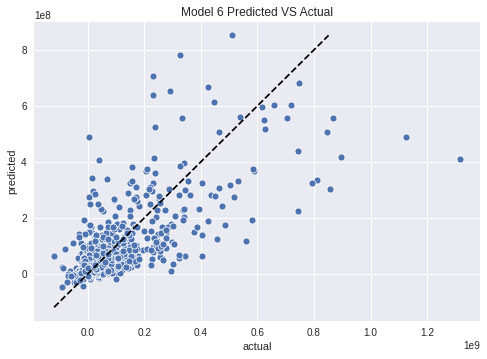

sklearn: rmse: 98688464.7686
r-squared: 0.7356


In [ ]:
plot_actual_predicted(y_test, knn2.predict(X_test[:,selected]), "Model 6 Predicted VS Actual")
plt.show();

rmse = np.sqrt(((knn2.predict(X_test[:,selected]) - y_test)**2).mean())
print('sklearn: rmse: {:.4f}'.format(rmse))
print('r-squared: {:.4f}'.format(knn2.score(X_train[:,selected], y_train)))

Above we can see that model 6 did a marginally better job than the other models at minimizing rmse.  Compared to its nearest competition, model 5 its rmse was more than 500000 dollars lower.  Although only 73.56 percent of the variation is explained by the model, a reasonable amount of points are close to the best fit line.  

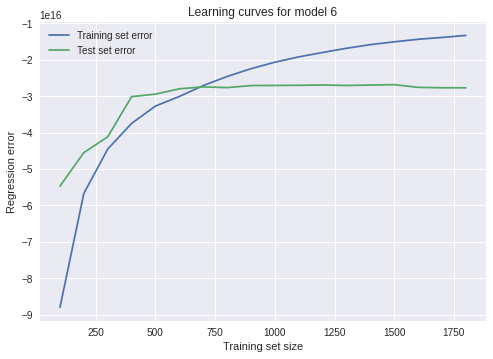

In [ ]:
train_sizes = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800]
train_sizes, train_scores, validation_scores = learning_curve(knn2.best_estimator_, X[:,selected], y, train_sizes = train_sizes, cv=5,scoring='neg_mean_squared_error')

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores.mean(axis=1), label = 'Training set error')
plt.plot(train_sizes, validation_scores.mean(axis=1), label = 'Test set error')
plt.ylabel('Regression error')
plt.xlabel('Training set size')
plt.title('Learning curves for model 6')
plt.legend();

As well, while taking a look at the learning curves for model 6 above we can see that systematic tuning was able to decrease the variance.  However, similar to other models using systematic feature selection we were unable to significantly reduce bias.  The test error in model 6 is still flattening quickly as training size increases.

# Conclusion

Overall we generated six different models, two for linear regression, two for tree regression and two KNN regression. Tree regression performed the worst overall for this dataset. Model 6 which used KNN regression gave us our lowest rmse value of 98688464.7686 dollars and an R^2 value of 0.7356. Model 2 had the best learning curve with the lowest prediction error for both the training set and test set. Also for model 2, after a training size of about 1000 the test curve followed the training curve pretty well. Model 2 would probably be the best for trying to predict net profit.  

In general we were able to decrease the amount of bias presented in the inital models through applying systematic feature, and parameter selection.  However, the majority of models still have relatively high amounts of bias in them.  This suggests that this was not the best set used to determine a movie's net profit.  The cause of bias in this data set is most likely due to the high variation in the net profit of movies.  So for future models of trying to predict a movie's net profit we need to take in consideration the scope of the movie.  